In [1]:
### replicate results of EVmutation with the PABP_YEAST dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from model import CouplingsModel
import tools
import scipy
from pathlib import Path
from collections import OrderedDict
# biopython SeqIO
from Bio import SeqIO
from sklearn.metrics import roc_auc_score
import scipy

In [8]:
NAME = 'PABP_YEAST'

In [9]:
### cut down training size to 10000 samples
yeast_seq_str = []
if NAME != "PABP_YEAST":
    number = NAME.split('_')[2]
    fasta_sequences = SeqIO.parse(open("PABP_YEAST/data/PABP_YEAST.a2m"),'fasta')
    with open(f"PABP_YEAST/data/{NAME}.a2m", "w+") as out_file:
        cnt = 0
        seq = []
        for fasta in fasta_sequences:
            yeast_seq_str.append(str(fasta.seq))
            if cnt < 10000:
                seq.append(fasta)
                cnt += 1
        SeqIO.write(seq, out_file, "fasta")

In [10]:
### training code for model
!plmc/bin/plmc -o PABP_YEAST/model/{NAME}.model_params -c PABP_YEAST/model/{NAME}.txt -f PABP_YEAST -le 16.2 -lh 0.01 -m 200 -t 0.2 -g PABP_YEAST/data/{NAME}.a2m

Found focus PABP_YEAST as sequence 1
151496 valid sequences out of 152041 
82 sites out of 96
Region starts at 115
^C


In [11]:
def EVmutation_results(NAME="PABP_YEAST"):
    # load parameters from file to create a pairwise model
    c = CouplingsModel(f"PABP_YEAST/model/{NAME}.model_params")
    # read the experimental mutational scanning dataset for PABP by Melamed et al., RNA, 2013
    data = pd.read_csv(
        "PABP_YEAST/data/PABP_YEAST_Fields2013-singles.csv", sep=";", comment="#"
    )

    # predict mutations using our model
    data_pred = tools.predict_mutation_table(
        c, data, "effect_prediction_epistatic"
    )

    # can also add predictions by the corresponding independent model
    c0 = c.to_independent_model()

    data_pred = tools.predict_mutation_table(
        c0, data_pred, "effect_prediction_independent"
    )
    print(data_pred.head())

    singles = tools.single_mutant_matrix(
        c, output_column="effect_prediction_epistatic"
    )

    print(singles.head())
    pred = data_pred['effect_prediction_epistatic']
    pred_ind = data_pred['effect_prediction_independent']
    label = data_pred['linear']

    cnt = 0
    for i in range(pred.shape[0]):
        if (label[i] >= 1 and pred[i] >= 0) or (label[i] < 1 and pred[i] < 0):
            cnt += 1
    print('accuracy: ', cnt/pred.shape[0])
    print('evmutation spearman: ', scipy.stats.spearmanr(pred, label))
    print('independent control spearman: ', scipy.stats.spearmanr(pred_ind, label))

In [13]:
EVmutation_results("PABP_YEAST")
print('=======')
# EVmutation_results("PABP_YEAST_10000")

  mutant    linear       log  effect_prediction_epistatic  \
0  G126A  0.711743 -0.490571                    -2.610615   
1  G126C  0.449027 -1.155127                    -5.663638   
2  G126E  0.588928 -0.763836                    -6.611062   
3  G126D  0.229853 -2.121218                    -7.270577   
4  G126N  0.679435 -0.557593                    -5.809167   

   effect_prediction_independent  
0                       0.406487  
1                      -0.027602  
2                      -1.827570  
3                      -1.180076  
4                       0.387440  
  mutant  pos wt subs  frequency  effect_prediction_epistatic
0  K123A  123  K    A   0.077201                     0.796669
1  K123C  123  K    C   0.001461                    -3.337328
2  K123D  123  K    D   0.118235                    -0.316713
3  K123E  123  K    E   0.110503                    -1.078200
4  K123F  123  K    F   0.007791                    -3.013274
accuracy:  0.8282828282828283
evmutation spearman: 

Running SVM on this set of data

In [7]:
ALPHABET_PROTEIN = '-ACDEFGHIKLMNPQRSTVWY'
# Protein amino acid alphabet + gap character "-"
alphabet = '-ACDEFGHIKLMNPQRSTVWY'
# map amino acids to index
aa_to_i = {aa:i for i, aa in enumerate(alphabet)}
# map index to amino acids
i_to_a = {i:aa for i, aa in enumerate(alphabet)}

In [8]:
def encode(seqs, alphabet=ALPHABET_PROTEIN):
    '''
    Go from letters to numbers
    '''
    aa_to_i = OrderedDict((aa, i) for i, aa in enumerate( alphabet ))
    X = np.asarray([[aa_to_i[x] for x in seq] 
                    for seq in seqs])
    return X, aa_to_i

def check_sequence(s, alphabet=ALPHABET_PROTEIN):
    for aa in s:
        if aa not in ALPHABET_PROTEIN:
            return False
    return True

def one_hot_encode(s):
    ''' one hot encode sequence'''
    return np.eye(21)[s].flatten()
def process_msa_sequence(msa_sequences):
    ''' takes in list of sequences and one-hot encodes the sequences'''
    # get wild-type sequence
    wt_seq = msa_sequences[0]
    # keep all the columns
    columns_to_keep = [i for i in range(len(wt_seq))]
    # upper case all letters
    msa_sequences = [[s[i].upper() for i in columns_to_keep] for s in msa_sequences]
    # replace "." with "-"
    msa_sequences = [[aa.replace(".", "-") for aa in s] for s in msa_sequences]
    msa_sequences = np.asarray(msa_sequences)
    # keep sequences that pass check_sequence
    msa_sequences = [s for s in msa_sequences if check_sequence(s)]
    msa_sequences = np.asarray(msa_sequences)

    seqs_enc, aa_to_i = encode(msa_sequences)
    oh_enc_seq = []
    for s in seqs_enc:
        oh_enc_seq.append(one_hot_encode(s))
    oh_enc_seq = np.asarray(oh_enc_seq)
    return oh_enc_seq

In [9]:
# read in fasta files
yeast_seq = [str(x.seq) for x in SeqIO.parse('EVmutation/example/PABP_YEAST.a2m', 'fasta')]
wildtype = yeast_seq[0]
yeast_seq = process_msa_sequence(yeast_seq)

In [13]:
### read in weights
weights = pd.read_csv('PABP_YEAST/data/seq_weights.csv')
weights = weights['weights'].to_numpy()
print(weights.shape)

(152041,)


In [20]:
from sklearn.svm import OneClassSVM

clf = OneClassSVM(kernel='poly', degree=2, nu=0.3)
train = yeast_seq[:50000]
clf.fit(train, sample_weight=weights[:50000])

OneClassSVM(degree=2, kernel='poly', nu=0.3)

In [21]:
data = pd.read_csv(
    "PABP_YEAST/data/PABP_YEAST_Fields2013-singles.csv", sep=";", comment="#"
)
mutant, label = data['mutant'].to_numpy(), data['linear'].to_numpy()
mutant_data = []
for m in mutant:
    original_aa, loc, mutant_aa = m[0], int(m[1:4])-115, m[4]
    assert wildtype[loc] == original_aa
    mutant_data.append(wildtype[:loc]+mutant_aa+wildtype[loc+1:])
mutant_data = np.asarray(mutant_data)
mutant_data = process_msa_sequence(mutant_data)

In [22]:
### about labelling in the data: for linear, > 1 --> generally neutral mutation, probability of neutral mutation decreases as
### enrichment score gets lower

In [23]:
train_pred = clf.decision_function(train[:10000])
msa_pred = clf.decision_function(yeast_seq[50000:60000])
mut_pred_pos = clf.decision_function(mutant_data[np.where(label>=1)])
mut_pred_neg = clf.decision_function(mutant_data[np.where(label<1)])


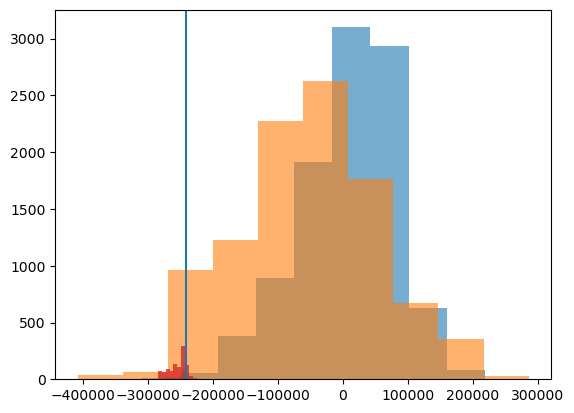

In [24]:
plt.hist(train_pred, alpha=0.6)
plt.hist(msa_pred, alpha=0.6)
plt.hist(mut_pred_pos, alpha=0.8)
plt.hist(mut_pred_neg, alpha=0.8)
plt.axvline(train_pred[0]) ## wildtype

G

(array([ 74.,  61.,  91.,  73., 135., 112., 293., 124.,  25.,   7.]),
 array([-284239.46045753, -278220.7664745 , -272202.07249147,
        -266183.37850844, -260164.68452541, -254145.99054238,
        -248127.29655935, -242108.60257632, -236089.90859329,
        -230071.21461026, -224052.52062723]),
 <BarContainer object of 10 artists>)

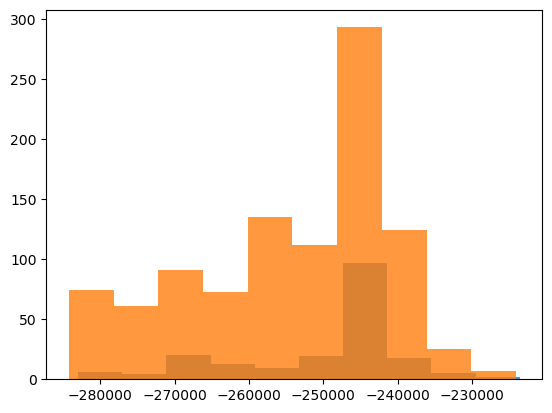

In [25]:
plt.hist(mut_pred_pos, alpha=0.8)
plt.hist(mut_pred_neg, alpha=0.8)

In [119]:
NAME = 'PABP_YEAST_10000'
c = CouplingsModel(f"PABP_YEAST/model/{NAME}.model_params")
pos_upper = [x for x in range(len(yeast_seq_str[0])) if not yeast_seq_str[0][x].islower()]
processed_yeast = [s for s in yeast_seq_str if not 'X' in s]
processed_yeast = [np.asarray(list(s))[pos_upper] for s in processed_yeast]
processed_yeast = [s for s in processed_yeast if not '-' in s]
# np.asarray(list(s))[pos_upper] for s in yeast_seq_str if not '-' in np.asarray(list(s))[pos_upper] and not 'X' in np.asarray(list(s))[pos_upper]
energies = c.hamiltonians(processed_yeast)[:, 0]
wt_energy = energies[0]

# c.hamiltonians([s])
data = pd.read_csv(
    "PABP_YEAST/data/PABP_YEAST_Fields2013-singles.csv", sep=";", comment="#"
)

# predict mutations using our model
data_pred = tools.predict_mutation_table(
    c, data, "effect_prediction_epistatic"
)
evm_pred = data_pred['effect_prediction_epistatic'].to_numpy()
evm_pred_pos = evm_pred[np.where(label>=1)]+wt_energy
evm_pred_neg = evm_pred[np.where(label<1)]+wt_energy

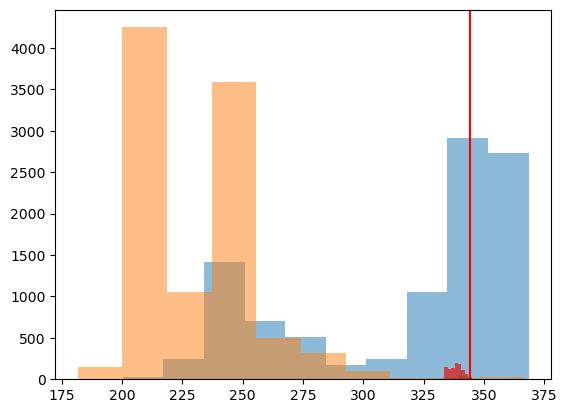

In [120]:
plt.hist(energies[:10000], alpha=0.5)
plt.hist(energies[10000:20000], alpha=0.5)
plt.hist(evm_pred_pos, alpha=0.8)
plt.hist(evm_pred_neg, alpha=0.8)
plt.axvline(wt_energy, color='red')

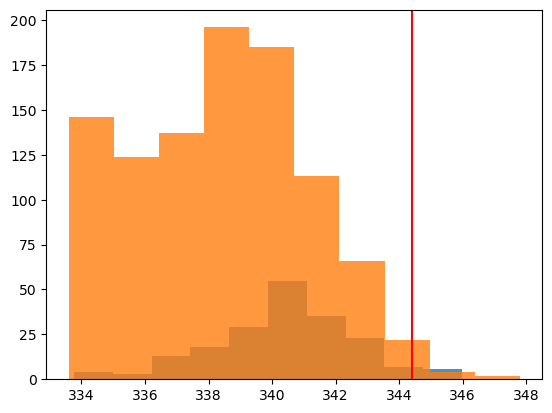

In [121]:
plt.hist(evm_pred_pos, alpha=0.8)
plt.hist(evm_pred_neg, alpha=0.8)
plt.axvline(wt_energy, color='red')

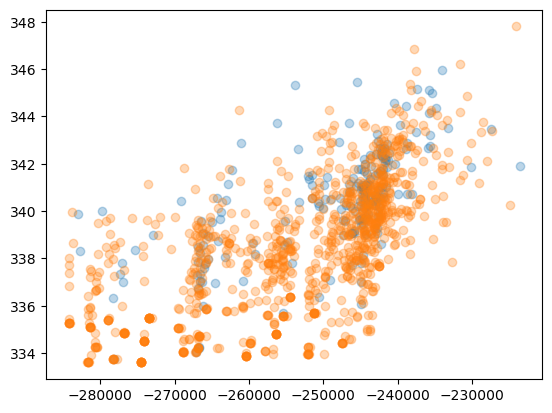

In [122]:
plt.scatter(x=mut_pred_pos, y=evm_pred_pos,alpha=0.3)
plt.scatter(x=mut_pred_neg, y=evm_pred_neg,alpha=0.3)

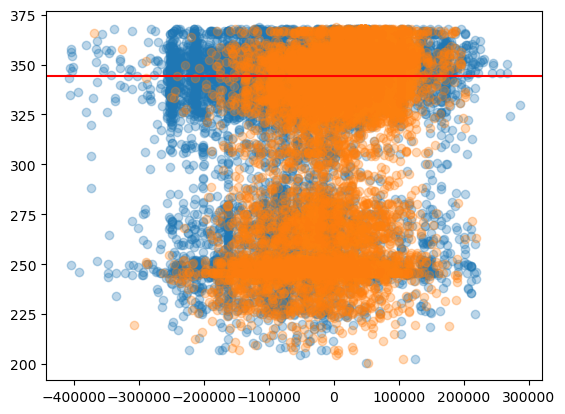

In [127]:
plt.scatter(x=msa_pred, y=energies[:10000],alpha=0.3)
plt.scatter(x=train_pred, y=energies[:10000],alpha=0.3)
plt.axhline(y=wt_energy, c='red')

Text(0.5, 1.0, 'EVMUTATION PREDICTIONS')

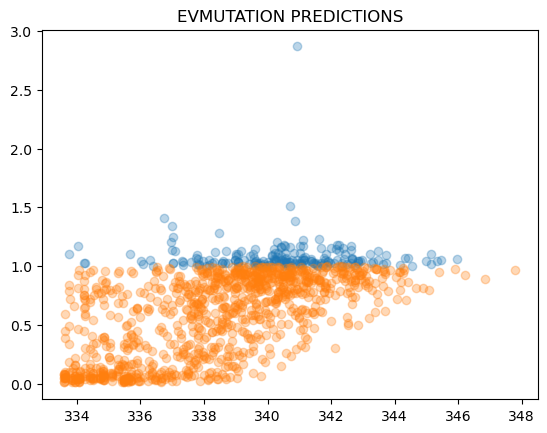

In [132]:
plt.scatter(x=evm_pred_pos, y=label[np.where(label>=1)], alpha=0.3)
plt.scatter(x=evm_pred_neg, y=label[np.where(label<=1)], alpha=0.3)
plt.title("EVMUTATION PREDICTIONS")

Text(0.5, 1.0, 'SVM PREDICTIONS')

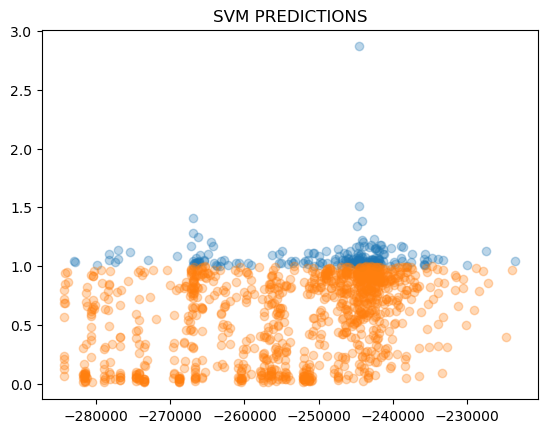

In [133]:
plt.scatter(x=mut_pred_pos, y=label[np.where(label>=1)], alpha=0.3)
plt.scatter(x=mut_pred_neg, y=label[np.where(label<=1)], alpha=0.3)
plt.title("SVM PREDICTIONS")